# K-means Clustering

### Import resources and display image

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn
from sklearn.metrics import silhouette_score
%matplotlib inline
BLUE = (0,0,255)
RED = (255,0,0)

### Read in an image

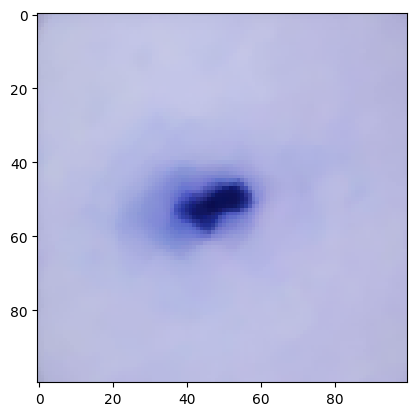

In [100]:
image = cv2.imread("0_initial.PNG")
plt.imshow(image)

### Change from BGR to RGB

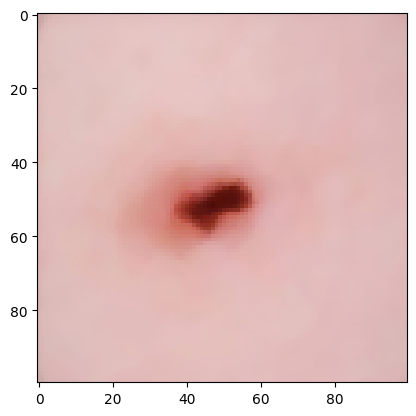

In [101]:
# Change color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

### Preprocessing

In [102]:
def fuzzy_rank_order_filter(image: np.ndarray, window_size: int = 3) -> np.ndarray:
    """
    Menerapkan Fuzzy Rank Order Filter (ROF) pada citra grayscale.

    Args:
        image (np.ndarray): Citra input (grayscale, dtype uint8).
        window_size (int): Ukuran jendela filter (harus ganjil, misal 3, 5, 7).

    Returns:
        np.ndarray: Citra hasil filter (dtype uint8).
    """
    if window_size % 2 == 0:
        raise ValueError("window_size harus ganjil.")
    
    pad_size = window_size // 2
    padded = np.pad(image, pad_size, mode='reflect')
    filtered_image = np.zeros_like(image, dtype=np.uint8)

    rows, cols = image.shape

    for i in range(rows):
        for j in range(cols):
            # Ambil jendela lokal
            window = padded[i:i + window_size, j:j + window_size].flatten()

            # Urutkan piksel
            sorted_window = np.sort(window)

            # Hitung statistik fuzzy
            mean = np.mean(sorted_window)
            std = np.std(sorted_window) + 1e-5  # Tambahan kecil untuk mencegah pembagian nol

            # Fungsi keanggotaan fuzzy Gaussian
            membership = np.exp(-((sorted_window - mean)**2) / (2 * std**2))

            # Normalisasi keanggotaan
            membership /= np.sum(membership)

            # Hitung nilai output sebagai rata-rata berbobot
            output_value = np.sum(membership * sorted_window)

            filtered_image[i, j] = np.clip(output_value, 0, 255)

    return filtered_image


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

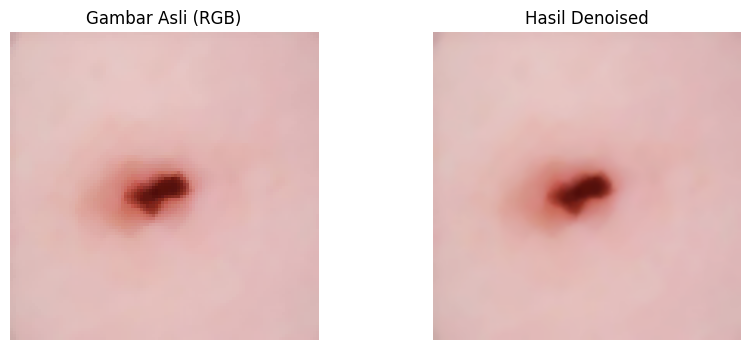

In [103]:
# Crop (center crop)
h, w = image.shape[:2]
center_x, center_y = w//2, h//2
crop_size = min(h, w) // 2
image_cropped = image[center_y-crop_size:center_y+crop_size, center_x-crop_size:center_x+crop_size]

# Resize to standard size
image_resized = cv2.resize(image_cropped, (512, 512))

# Noise Reduction - Gaussian Blur
b, g, r = cv2.split(image_resized)

# Terapkan filter FOZ ke masing-masing channel
b_filt = fuzzy_rank_order_filter(b, window_size=3)
g_filt = fuzzy_rank_order_filter(g, window_size=3)
r_filt = fuzzy_rank_order_filter(r, window_size=3)

# Gabungkan kembali
image_denoised = cv2.merge([b_filt, g_filt, r_filt])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Gambar Asli (RGB)')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Hasil Denoised')
plt.imshow(image_denoised)
plt.axis('off')

### Hue Enchancment, Histogram Equalization, dan Min-Max Normalization

In [104]:
def enhance_lesion_hsv(image_rgb):
    """
    Versi yang disesuaikan untuk gambar dengan lesi samar di warna kulit terang.
    """
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(image_hsv)

    # Konversi hue ke derajat
    hue_deg = h.astype(np.float32) * 2

    # Mask khusus: melanoma (10–50°), kulit normal (60–140°)
    mask_melanoma = (hue_deg >= 10) & (hue_deg <= 50)
    mask_skin = (hue_deg >= 60) & (hue_deg <= 160)

    # Perkuat rona dan terang melanoma
    hue_deg[mask_melanoma] = np.clip(hue_deg[mask_melanoma] * 1.4, 0, 360)
    # Redam rona dan terang kulit
    hue_deg[mask_skin] = np.clip(hue_deg[mask_skin] * 0.75, 0, 360)

    # Kembalikan dan gabungkan
    h_new = np.clip(hue_deg / 2, 0, 179).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    v_new = clahe.apply(v)
    enhanced_hsv = cv2.merge([h_new, s, v_new])
    enhanced_rgb = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2RGB)
    
    return enhanced_rgb

In [105]:
def enhance_lesion_hsv_v2(image_rgb, gamma=0.8):
    """
    Peningkatan HSV untuk lesi samar:
    - Penguatan selektif pada Hue melanoma
    - Reduksi rona kulit
    - CLAHE + Min-Max + Gamma correction untuk kontras global
    """
    # Konversi ke HSV
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(image_hsv)

    # Konversi Hue ke derajat
    hue_deg = h.astype(np.float32) * 2

    # Mask: melanoma dan kulit normal
    mask_melanoma = (hue_deg >= 10) & (hue_deg <= 50)
    mask_skin = (hue_deg >= 60) & (hue_deg <= 160)

    # Perkuat rona melanoma, reduksi rona kulit
    hue_deg[mask_melanoma] = np.clip(hue_deg[mask_melanoma] * 1.4, 0, 360)
    hue_deg[mask_skin] = np.clip(hue_deg[mask_skin] * 0.75, 0, 360)
    h_new = np.clip(hue_deg / 2, 0, 179).astype(np.uint8)

    # Langkah 1: CLAHE untuk lokal kontras
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    v_clahe = clahe.apply(v)

    # Langkah 2: Normalisasi Min-Max (untuk merentangkan hasil CLAHE)
    v_minmax = cv2.normalize(v_clahe, None, 0, 255, cv2.NORM_MINMAX)

    # Langkah 3: Gamma correction (untuk menerangkan global)
    inv_gamma = 1.0 / gamma
    gamma_table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    v_final = cv2.LUT(v_minmax.astype(np.uint8), gamma_table)

    # Rekonstruksi HSV -> RGB
    enhanced_hsv = cv2.merge([h_new, s, v_final])
    enhanced_rgb = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2RGB)

    return enhanced_rgb

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

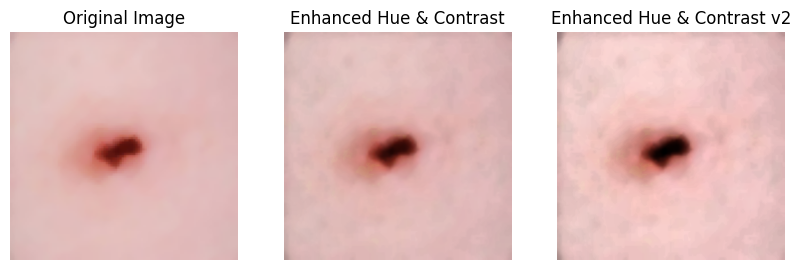

In [106]:
image_enhanced = enhance_lesion_hsv(image_denoised)
image_enhancedv2 = enhance_lesion_hsv_v2(image_denoised)
# Tampilkan hasil
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_enhanced)
plt.title("Enhanced Hue & Contrast")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_enhancedv2)
plt.title("Enhanced Hue & Contrast v2")
plt.axis('off')


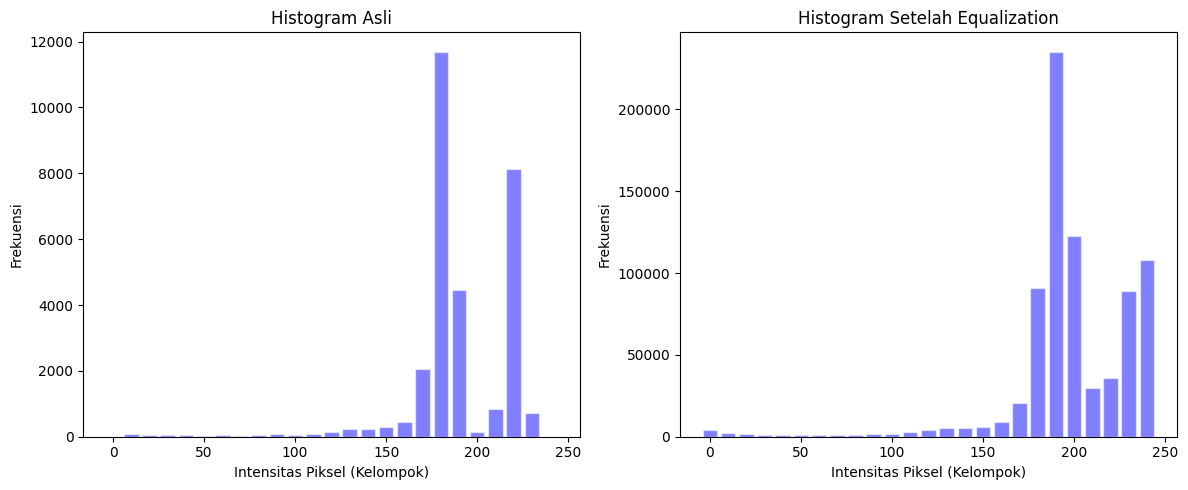

In [118]:
bin_size = 10
bins = np.arange(0, 256, bin_size)
hist_original, _ = np.histogram(image, bins=bins)
hist_equalized, _ = np.histogram(image_enhancedv2, bins=bins)

# Plot histogram
plt.figure(figsize=(12, 5))

# Histogram Asli
plt.subplot(1, 2, 1)
plt.bar(bins[:-1], hist_original, width=8, color='blue', edgecolor='white', alpha=0.5)
plt.title("Histogram Asli")
plt.xlabel("Intensitas Piksel (Kelompok)")
plt.ylabel("Frekuensi")
plt.xticks(np.arange(0, 256, 50)) 

# Histogram Setelah Equalization
plt.subplot(1, 2, 2)
plt.bar(bins[:-1], hist_equalized, width=8, color='blue', edgecolor='white', alpha=0.5)
plt.title("Histogram Setelah Equalization")
plt.xlabel("Intensitas Piksel (Kelompok)")
plt.ylabel("Frekuensi")
plt.xticks(np.arange(0, 256, 50))

plt.tight_layout()
plt.show()

### Reshape image to 2d array

In [119]:
pixel_vals = image_enhancedv2.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

### AUTOMATIC K SELECTION

Testing k values: 1, 2, 3, 4, 5, 6, 7, 8, 

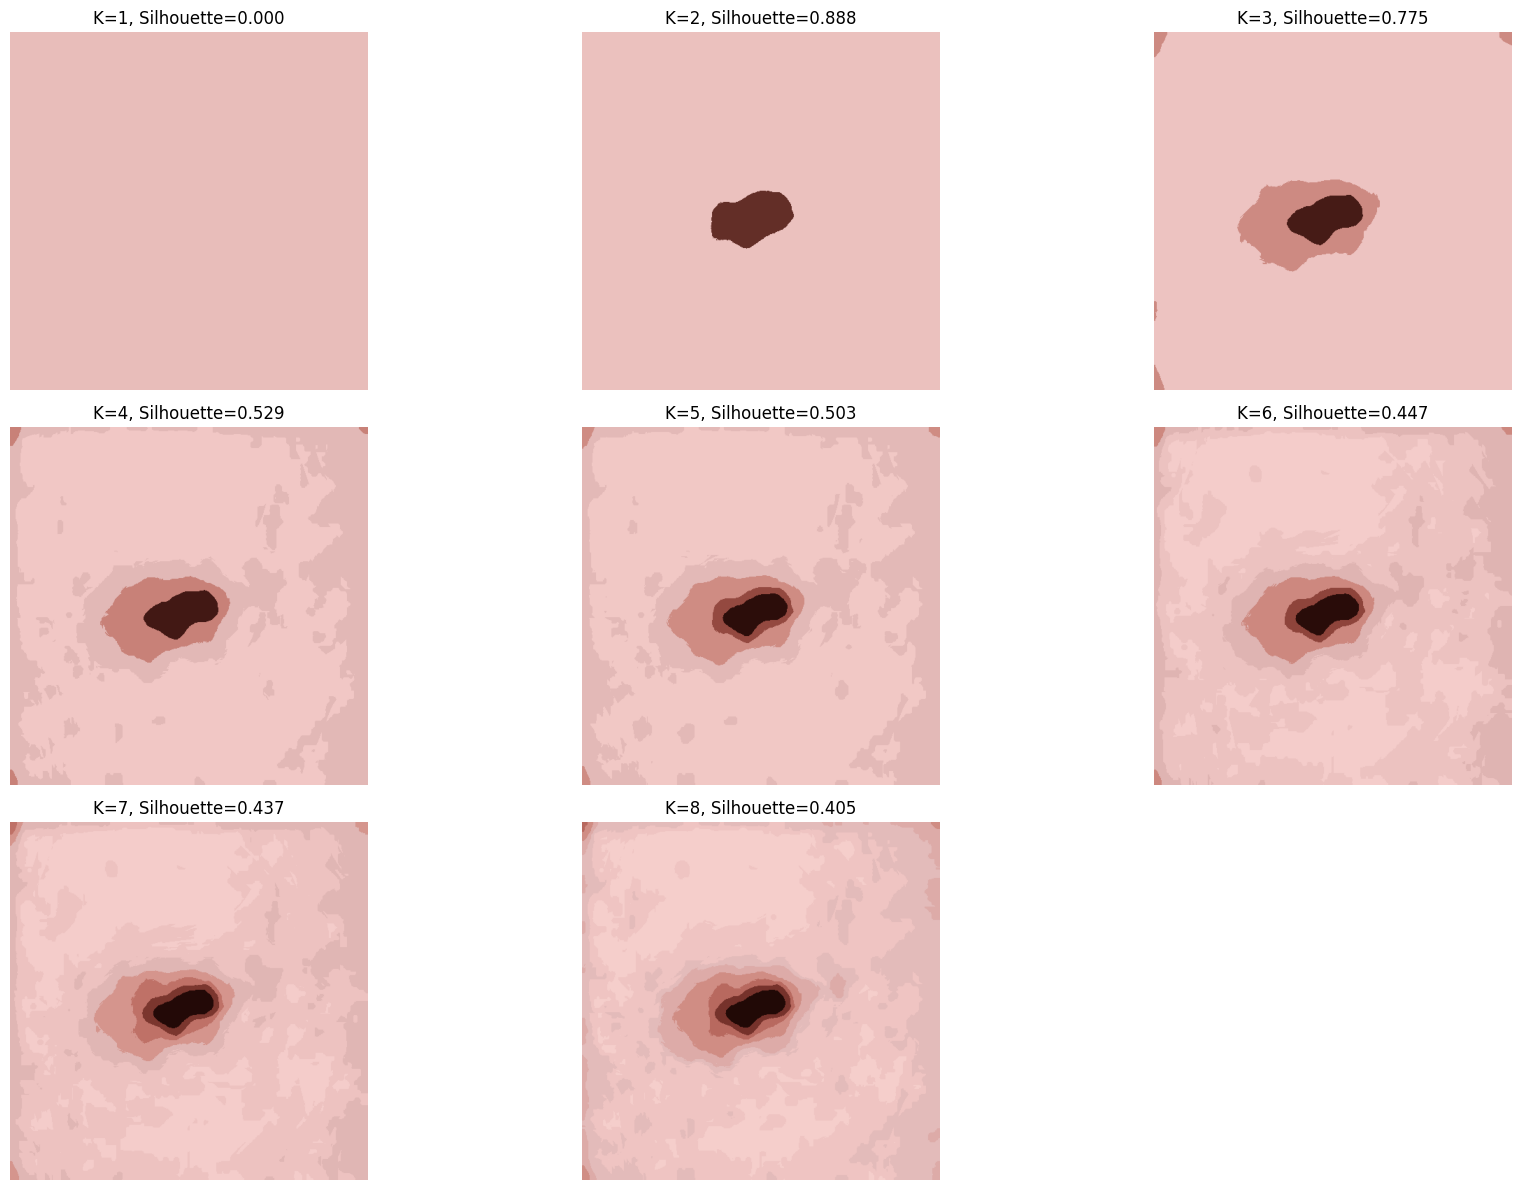

In [120]:
# OPTIMASI 1: Reduce image size for faster clustering
original_shape = image_enhancedv2.shape
scale_factor = 0.25 
small_img = cv2.resize(image_enhancedv2, 
                      (int(original_shape[1] * scale_factor), 
                       int(original_shape[0] * scale_factor)))

# OPTIMASI 2: Sample pixels instead of using all pixels
pixel_vals_small = small_img.reshape((-1,3))
pixel_vals_small = np.float32(pixel_vals_small)

# OPTIMASI 3: Further sampling if still too large
max_samples = 5000
if len(pixel_vals_small) > max_samples:
    indices = np.random.choice(len(pixel_vals_small), max_samples, replace=False)
    pixel_vals_sampled = pixel_vals_small[indices]
else:
    pixel_vals_sampled = pixel_vals_small

# Test different k values for automatic selection
k_range = [1,2,3, 4, 5, 6, 7, 8]
silhouette_scores = []
inertias = []
clustering_results = {}

# OPTIMASI 4: Reduced criteria for faster convergence
fast_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)

plt.figure(figsize=(18, 12))  # Ukuran lebih besar untuk 9 plot

print("Testing k values:", end=" ")
for i, k in enumerate(k_range):
    print(f"{k},", end=" ")
    retval, labels_small, centers = cv2.kmeans(pixel_vals_sampled, k, None, fast_criteria, 5, cv2.KMEANS_RANDOM_CENTERS)
    if len(np.unique(labels_small)) > 1:
        sil_score = silhouette_score(pixel_vals_sampled, labels_small.flatten())
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(0)
    inertias.append(retval)
    
    retval_full, labels_full, centers_full = cv2.kmeans(pixel_vals, k, None, criteria, 5, cv2.KMEANS_RANDOM_CENTERS)
    clustering_results[k] = {
        'retval': retval_full,
        'labels': labels_full, 
        'centers': centers_full
    }
    
    centers_vis = np.uint8(centers_full)
    segmented_data = centers_vis[labels_full.flatten()]
    segmented_image = segmented_data.reshape((image_enhancedv2.shape))
    
    plt.subplot(3, 3, i+1)  # 3x3 grid = cukup untuk 8 nilai k
    plt.imshow(segmented_image)
    plt.title(f'K={k}, Silhouette={silhouette_scores[i]:.3f}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [121]:
# Find optimal k
best_k_idx = np.argmax(silhouette_scores)
optimal_k = k_range[best_k_idx]
best_silhouette = silhouette_scores[best_k_idx]

print(f"Optimal k selected automatically: {optimal_k}")
print(f"Best silhouette score: {best_silhouette:.3f}")

Optimal k selected automatically: 2
Best silhouette score: 0.888


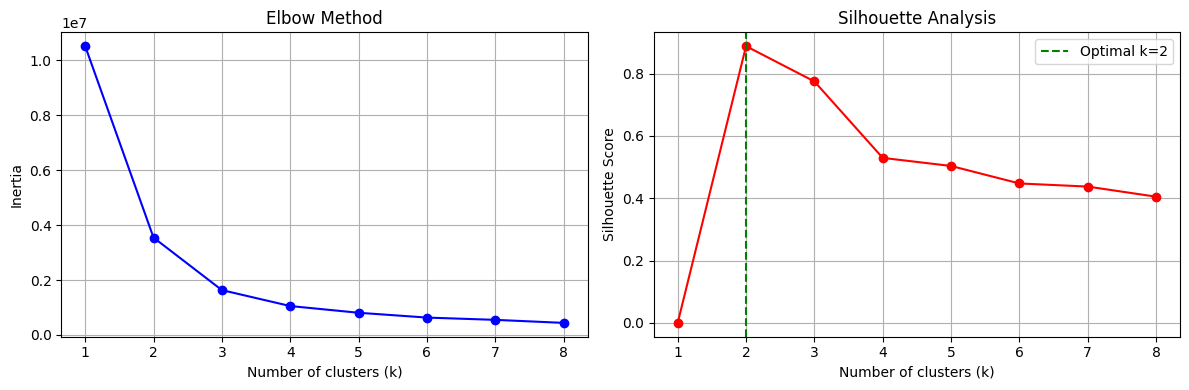

In [122]:
# Plot analysis charts
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.axvline(x=optimal_k, color='green', linestyle='--', label=f'Optimal k={optimal_k}')
plt.legend()

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

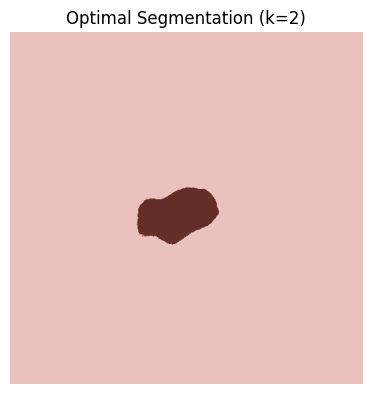

In [123]:
# Use optimal clustering result
k = optimal_k
retval, labels, centers = clustering_results[k]['retval'], clustering_results[k]['labels'], clustering_results[k]['centers']

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape((image_enhancedv2.shape))
labels_reshape = labels.reshape(image_enhancedv2.shape[0], image_enhancedv2.shape[1])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f'Optimal Segmentation (k={optimal_k})')
plt.imshow(segmented_image)
plt.axis('off')

### Mask image by cluster

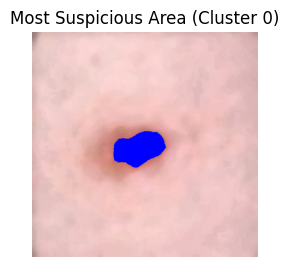

(512, 512, 3)


In [124]:
# Simple automatic cluster selection based on darkness (typical melanoma characteristic)
unique_labels = np.unique(labels_reshape)
darkest_cluster = None
darkest_value = 255 

for cluster_id in unique_labels:
    mask = labels_reshape == cluster_id
    cluster_pixels = image_enhancedv2[mask]
    mean_brightness = np.mean(cluster_pixels)
    
    if mean_brightness < darkest_value:
        darkest_value = mean_brightness
        darkest_cluster = cluster_id

# Automatic masking code
cluster = darkest_cluster 
masked_image = np.copy(image_enhancedv2) # masih bingung pakai image/hasil equalized
masked_image[labels_reshape == cluster] = [BLUE]

plt.subplot(1, 2, 2)
plt.title(f'Most Suspicious Area (Cluster {cluster})')
plt.imshow(masked_image)
plt.axis('off')
plt.show()

print(masked_image.shape)

Bounding Box Generation

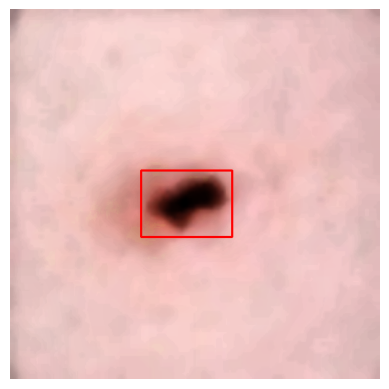

In [133]:

# Convert the masked image to HSV
hsv_img = cv2.cvtColor(masked_image, cv2.COLOR_RGB2HSV)

# Define the color range for the cluster
lower_blue = np.array([120, 255, 150], np.uint8)
upper_blue = np.array([120, 255, 255], np.uint8)

# Threshold the image to isolate the cluster
frame_threshed = cv2.inRange(hsv_img, lower_blue, upper_blue)

# Find contours
imgray = frame_threshed
ret, thresh = cv2.threshold(frame_threshed, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
areas = [cv2.contourArea(c) for c in contours]
max_index = np.argmax(areas)
cnt = contours[max_index]

# Get bounding box coordinates
x, y, w, h = cv2.boundingRect(cnt)

# Add padding to the bounding box
pad_w, pad_h, pad_x, pad_y = 4, 5, 3, 4
cv2.rectangle(image_enhancedv2, (x - pad_x, y - pad_y), (x + w + pad_w, y + h + pad_h), (255, 0, 0), 2)

# Display the image with the bounding box
plt.imshow(image_enhancedv2)
plt.axis('off')
plt.show()